## Validating step2 script
* 09/27: created 

In [1]:
!python --version

Python 2.7.13 :: Continuum Analytics, Inc.


In [2]:
import os

os.environ['CONDA_DEFAULT_ENV']

'K2phot'

In [3]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
import os 

## raw

In [4]:
inputpath = '/home/jp/github/transit/cranky/output/24866269/detrended_lc_24866269.txt'
outputfolder = 'output/'
starname='24866269'

lc = np.loadtxt(inputpath,comments='#',delimiter=' ', dtype=float)
t,f=lc[:,0],lc[:,1]

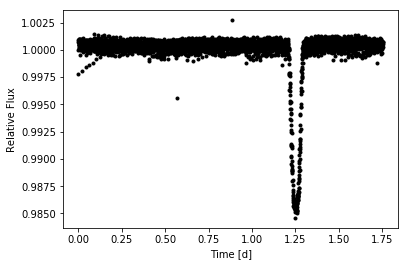

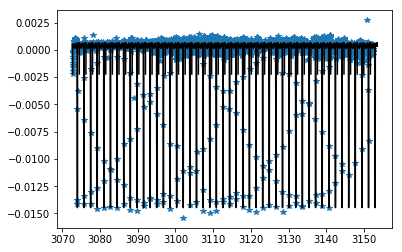

In [5]:
from k2crank.periodfinder import get_period
from k2crank.findplanet import find_period

use_BLS=True

if use_BLS:
    folded,t_folded,period,freqlist,powers = get_period(t,f,[],
                                            get_mandelagolmodel=False,
                                            outputpath=outputfolder,
                                            starname=starname)
else: #Lomb-Scargle periodogram
    period,powers=find_period(t,f,outputfolder=outputfolder,starname=starname)

In [6]:
def estimate_k(t,f,p,showfig=False):
    '''
    k=Rp/Rs estimate transit depth assumed to be within 0.01 percentile
    '''
    baseline,minimum=np.percentile(f[np.array(t%p).argsort()], [50,1])
    if showfig:
        pl.hist(f[np.array(t%p).argsort()]);
    #print(baseline,minimum)
    return np.sqrt(baseline-minimum)

k=estimate_k(t,f,period)

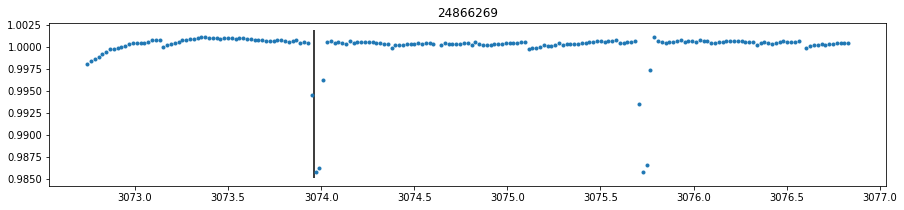

In [7]:
def estimate_t0(t,f,tlower=None,tupper=None, showfig=False,outputfolder='',starname=''):
    '''
    very basic search for t0 given interval tlower and tupper
    '''
    if tlower is None and tupper is None:
        tlower, tupper=t[0],t[200]
    idx = (t > tlower) & (t < tupper)
    tsub, fsub = t[idx], f[idx]
    idx = fsub < np.median(fsub) - 0.5 * np.nanstd(fsub)
    t0 = np.median(tsub[idx])
    if showfig:
        fig, ax = pl.subplots(1,1,figsize=(15,3))
        ax.plot(tsub, fsub, '.')
        ax.set_title(starname)
        ax.vlines(t0, *ax.get_ylim())
    return t0

t0 = estimate_t0(t,f,tlower=t[0],tupper=t[200],showfig=True,outputfolder=outputfolder,starname=starname)

In [8]:
def get_tns(t, p, t0):
    '''
    determine transit conjuctions
    '''

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns

tns=get_tns(t, period, t0)

In [9]:
def estimate_t14(value=0.01):
    if value:
        return value
    
def t14_circ(p, a, k, b):
    """
    Winn 2014 ("Transits and Occultations"), eq. 14
    """
    i = inclination(a, b)
    alpha = np.sqrt( (1 + k)**2 - b**2 )
    return (p / np.pi) * np.arcsin( alpha / np.sin(i) / a )

def scaled_a(p, t14, k, i=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

def inclination(a, b, e=None, w=None):
    """
    Winn 2014 ("Transits and Occultations"), eq. 7
    """
    # if e is None and w is None:
    #     return np.arccos(b / a)
    # elif e is not None and w is not None:
    #     return np.arccos(b / a * (1 + e * np.sin(w)) / (1 - e**2))
    # else:
    #     return np.nan
    return np.arccos(b / a)

def q_to_u(q1, q2):
    u1 = 2 * np.sqrt(q1) * q2
    u2 = np.sqrt(q1) * (1 - 2*q2)
    return u1, u2

def u_to_q(u1, u2):
    q1 = (u1 + u2)**2
    q2 = u1 / (2 * (u1 + u2))
    return q1, q2


def tshape_approx(a, k, b):
    """
    Seager & Mallen-Ornelas 2003, eq. 15
    """
    i = inclination(a, b)
    alpha = (1 - k)**2 - b**2
    beta = (1 + k)**2 - b**2
    return np.sqrt( alpha / beta )


def max_k(tshape):
    """
    Seager & Mallen-Ornelas 2003, eq. 21
    """
    return (1 - tshape) / (1 + tshape)

In [10]:
def fold(t, f, p, t0, width=0.4, t14=0.1):
    '''
    fold lc; very sensitive to p & t0
    '''
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    return tf, ff

In [11]:
def fold_with_eclipse(t, f, p, t0, width=0.4, t14=0.1, odd_even=False):
    '''
    fold lc; very sensitive to p & t0
    '''
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    
    #for odd_even
    tf1, ff1 = np.empty(0), np.empty(0)
    tf2, ff2 = np.empty(0), np.empty(0)
    
    if odd_even:
        for i,tn in enumerate(tns[1::2]): #odd
            idx_odd = (t > tn - width/2.) & (t < tn + width/2.)
            ti1 = t[idx_odd]-tn
            fi1 = f[idx_odd]
            fi1 /= np.nanmedian(fi1)
            tf1 = np.append(tf1, ti1)
            ff1 = np.append(ff1, fi1 / np.nanmedian(fi1))
        
        idx_odd = np.argsort(tf1)
        tf1 = tf1[idx_odd]
        ff1 = ff1[idx_odd]
        
        for i,tn in enumerate(tns[::2]): #even
            idx_even = (t > tn - width/2.) & (t < tn + width/2.)
            ti2 = t[idx_even]-tn
            fi2 = f[idx_even]
            fi2 /= np.nanmedian(fi2)
            tf2 = np.append(tf2, ti2)
            ff2 = np.append(ff2, fi2 / np.nanmedian(fi2))
        
        idx_even = np.argsort(tf2)
        tf2 = tf2[idx_even]
        ff2 = ff2[idx_even]
        
        return tf1, ff1, tf2,ff2
    else:
        for i,tn in enumerate(tns):
            idx = (t > tn - width/2.) & (t < tn + width/2.)
            ti = t[idx]-tn
            fi = f[idx]
            fi /= np.nanmedian(fi)
            tf = np.append(tf, ti)
            ff = np.append(ff, fi / np.nanmedian(fi))

        idx = np.argsort(tf)
        tf = tf[idx]
        ff = ff[idx]
        return tf, ff

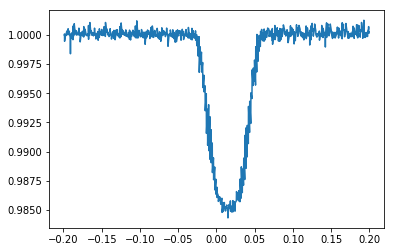

In [12]:
tt,ff=fold(t,f,period,t0)
pl.plot(tt,ff)

In [13]:
p = period
k = estimate_k(t,f,p)
b = 0.1
#estimate initial for t14
t14 = estimate_t14()
a_au = scaled_a(p, t14, k, b=b)
t14 = t14_circ(p, a_au, k, b=b)

#i = inclination(a_au, b=b) #np.pi/2.

#u1, u2 = 0.2, 0.2
#q1, q2=u_to_q(u1, u2)
q1,q2 = 0.2,0.2
sig = f.std()

initial = k,t0,p,a_au,b,q1,q2,sig
args = (t, f)

tt,ff = fold(t,f,p,t0)
#adjust t0
t0_fold=estimate_t0(tt,ff, tlower=tt[len(tt)/2-30], tupper=tt[len(tt)/2+30])
initial_fold = k,t0_fold,p,a_au,b,q1,q2,sig
args_fold = (tt, ff)


tshape=tshape_approx(a_au, k, b)
tshape_lim=max_k(tshape)

In [14]:
def model_q(theta, t):
    MA = MandelAgol()
    k,tc,p,a,b,q1,q2,_ = theta
    i     = inclination(a, b)
    u1,u2 = q_to_u(q1, q2)
    model = MA.evaluate(t, k, (u1,u2), tc, p, a, i)

    return model


def lnlike(theta, t, f):
    k,t0,p,a,b,q1,q2,sig = theta
    m = model_q(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))

from scipy import stats

def lnprob(theta, t, f, folded=False):
    k,t0,p,a,b,q1,q2,sig = theta
    #logprior
#     if t0 < -1 or t0 > 1:
#         return -np.inf
    if q1 < 0 or q1 > 1 or q2 < 0 or q2 > 1 or b < 0 or b > 1 or k < 0 or k > 1:
        return -np.inf

    u1, u2 = q_to_u(q1, q2)

    lp = 0
#     if up is not None:
#         lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
#         lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))

    #loglike
    ll = lnlike(theta, t, f)

    if np.isnan(ll).any():
        return -np.inf
    return lp + ll

In [15]:
from pytransit import MandelAgol
import scipy.optimize as op

def fit_folded_lc(initial, args, method='powell',verbose=True):
    '''
    `Powell` method minimises the function by a bi-directional search along each search vector, in turn
    '''
    nlp = lambda *args: -lnprob(*args)

    opt = op.minimize(nlp, initial, args=args, method=method)
    labels='k,t0,p,a,i,q1,q2,sig'.split(',')

    if verbose:
        print('converged: {}'.format(opt.success))
        for i,j in zip(labels,opt.x):
            print('{0}: {1}'.format(i,j))
    return opt

opt=fit_folded_lc(initial, args, verbose=True)

/home/jp/miniconda2/envs/K2phot/lib/python2.7/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


converged: True
k: 0.099211421117
t0: 3073.97829331
p: 1.75555187719
a: 7.26474554458
i: 0.396053017348
q1: 0.772178775602
q2: 0.999547981496
sig: -0.000567453263603


In [16]:
def plot_fit(theta,t,f,show_model=True,outputfolder='',starname='', folded=False):
    t0, p = theta[1], theta[2]
    #f /= np.median(f)
    fig, ax = pl.subplots(1,1,figsize=(15,5))
    
    if folded:
        #t,f and t0 are folded
        ax.plot(t, f, '.', label='data')
        #note that t0 in theta is t0_fold
        fmod=model_q(theta, t) 
        ax.plot(t,fmod,'r.-',label='model')
        residual = f - fmod
        
    else:
        #t,f must be folded
        tf, ff = fold(t, f, p, t0)
        ax.plot(tf, ff, '.', label='data')
        fmod=model_q(theta, t)
        ttmod,ffmod=fold(t,fmod,p,t0)
        residual = ff - ffmod
        ax.plot(ttmod,ffmod,'r.-',label='model')
        
    rms = np.sqrt(np.mean(residual**2))
    ax.set_xlabel('Phase')
    ax.set_ylabel('Normalized Flux')
    ax.set_title('Phase-folded with model fit (MLE): {}'.format(starname))
    ax.legend()
    #pl.savefig(join(outputfolder, 'folded_model_optimized_fit' + str(starname) + '.png'))
    return rms

0.00041612046919684378

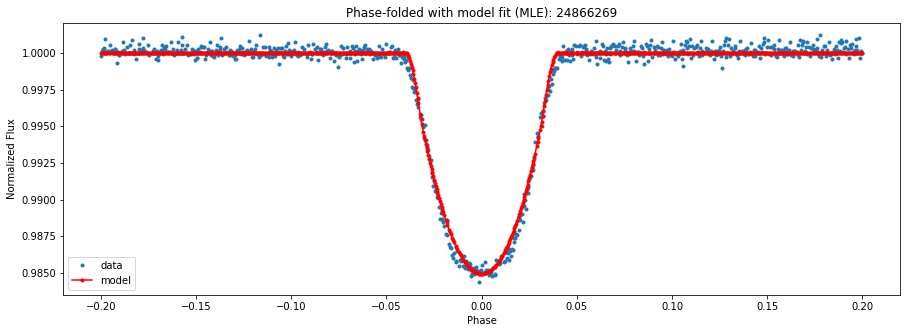

In [17]:
plot_fit(opt.x,t,f,outputfolder=outputfolder,starname=starname, folded=False)

In [18]:
tshape=tshape_approx(a_au, k, b)
tshape

0.78431925289841675

In [19]:
tshape_lim=max_k(tshape)
tshape_lim

0.12087564865493394

In [20]:
snr = np.max(powers)/np.median(powers)
snr

19.595399090940425

In [21]:
np.rad2deg(inclination(a_au, b))

89.908070736401925

## Summary plot

In [22]:
from gatspy.periodic import LombScargleFast

def find_period_combo(t,f,showfig=True,outputfolder='',starname=''):
    '''
    uses Lomb-Scargle to find planet's orbital period
    '''
    model = LombScargleFast().fit(t, f)
    periods, power = model.periodogram_auto(nyquist_factor=100)
    idx1 = periods > 1
    idx2 = np.argmax(power[idx1])
    period = periods[idx1][idx2]
    
    if showfig:
        fig, ax = pl.subplots(1,1,figsize=(15,5))
        ax.plot(periods, power, 'k-')
        ax.set(xlim=(0.5, 5),
        #         , ylim=(0, 0.01),
           xlabel='period (days)',
           ylabel='Lomb-Scargle Power')
        ax.vlines(period, *ax.get_ylim(), linestyles='dotted', colors='r')
        ax.set_title('best period: {0:.3f}'.format(period))
    return period, periods, power

  
#pl.savefig(join(outputfolder, 'LombScargle_' + str(starname) + '.png'))

In [23]:
len(1./freqlist)==len(powers)

True

raw light curve done
bls periodogram done
lomb-scargle periodogram done
primary transit model fitting done
secondary eclipse model fitting done
odd period phase-folding done
even period phase-folding done


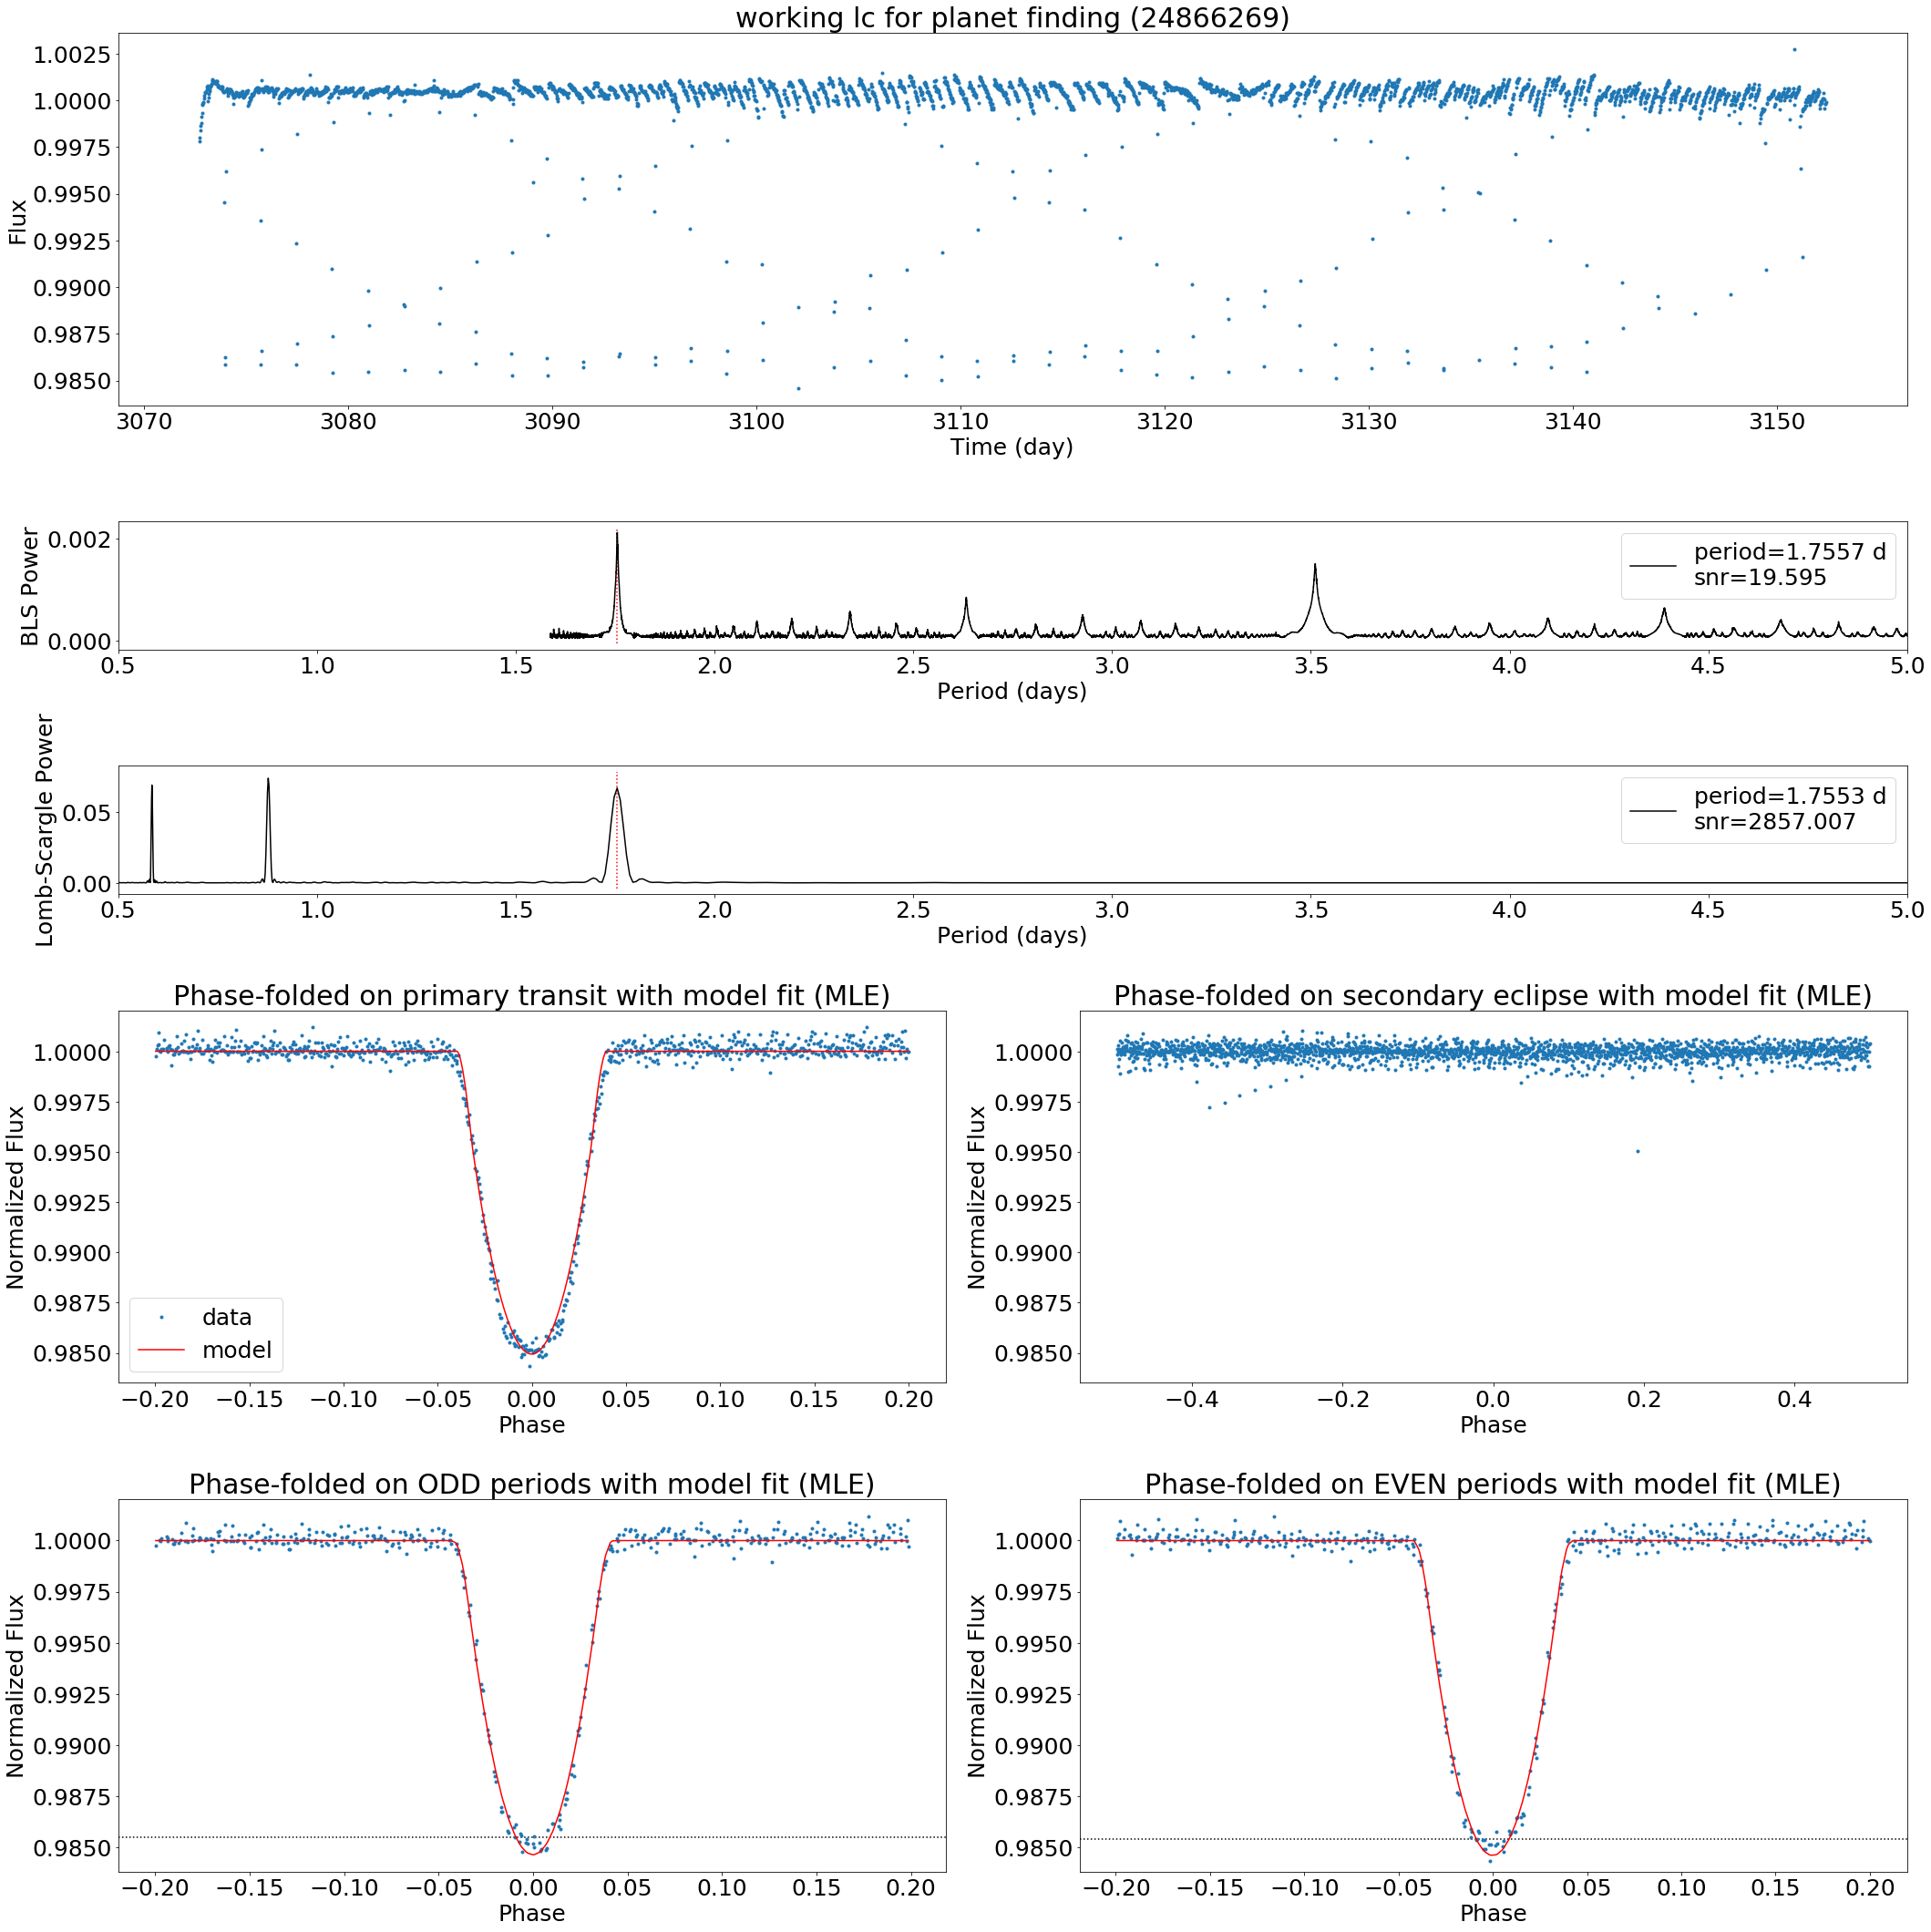

In [24]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 25

fig = pl.figure('Quick Look',figsize=(30.,30.))

rows,cols= 8,2
ax1 = pl.subplot2grid((rows,cols), (0,0), colspan=3,rowspan=2)
ax2 = pl.subplot2grid((rows,cols), (2,0), colspan=3)
ax3 = pl.subplot2grid((rows,cols), (3,0), colspan=3)
ax4 = pl.subplot2grid((rows,cols), (4,0), rowspan=2)
ax5 = pl.subplot2grid((rows,cols), (4,1), rowspan=2)
ax6 = pl.subplot2grid((rows,cols), (6,0), rowspan=2)
ax7 = pl.subplot2grid((rows,cols), (6,1), rowspan=2)

#--------------------raw lightcurve--------------------#
print('raw light curve done')
ax1.plot(t, f, '.')
ax1.set_ylabel('Flux')
ax1.set_xlabel('Time (day)')
ax1.set_title('working lc for planet finding ({})'.format(starname))

#--------------------BLS periodogram--------------------#
print('bls periodogram done')
if use_BLS:
    pass
else:
    folded,t_folded,period,freqlist,powers = get_period(t,f,[],
                                                get_mandelagolmodel=False)
ax2.plot(1./freqlist, powers, 'k-')
ax2.set(xlim=(0.5, 5), #, ylim=(0, 0.01),
        xlabel='Period (days)',
        ylabel='BLS Power')
snr_bls = np.max(powers)/np.median(powers)
ax2.legend(['period={0:.4f} d\nsnr={1:.3f}'.format(period,snr_bls)],loc=1)
ax2.vlines(period, *ax2.get_ylim(), linestyles='dotted', colors='r')

#--------------------LS periodogram--------------------#
print('lomb-scargle periodogram done')
period, periods, powers = find_period_combo(t,f,showfig=False)

ax3.plot(periods, powers, 'k-')
ax3.set(xlim=(0.5, 5), #, ylim=(0, 0.01),
        xlabel='Period (days)',
        ylabel='Lomb-Scargle Power')
snr_ls = np.max(powers)/np.median(powers)
ax3.legend(['period={0:.4f} d\nsnr={1:.3f}'.format(period,snr_ls)],loc=1)
ax3.vlines(period, *ax3.get_ylim(), linestyles='dotted', colors='r')

#--------------------model fit--------------------#
# tf, ff = fold(t, f, period, t0)

# ax3.plot(tf, ff, '.')
# ax3.set_title('Phase-folded lc before optimization')
# ax3.set_xlabel('Phase')
# ax3.set_ylabel('Normalized Flux')

print('primary transit model fitting done')

opt=fit_folded_lc(initial, args, verbose=False)
t0, p = opt.x[1], opt.x[2]

tf, ff = fold(t, f, p, t0)

ax4.plot(tf, ff, '.', label='data')
ax4.set_xlabel('Phase')
ax4.set_ylabel('Normalized Flux')
fmod=model_q(opt.x, t)
ttmod,ffmod=fold(t,fmod,p,t0)
ax4.plot(ttmod,ffmod,'r-',label='model')
ax4.set_title('Phase-folded on primary transit with model fit (MLE)')
ax4.legend()

#--------------------secondary eclipse--------------------#
print('secondary eclipse model fitting done')
tf2,ff2=fold(t, f, period, t0+period/2, width=1, t14=0.1)

ax5.plot(tf2, ff2, '.', label='data')
ax5.set_title('Phase-folded on secondary eclipse with model fit (MLE)')
ax5.set_xlabel('Phase')
ax5.set_ylabel('Normalized Flux')
ax5.set_ylim(*ax4.get_ylim())

#--------------------odd--------------------#
print('odd period phase-folding done')

tf_odd,ff_odd, tf_even,ff_even = fold_with_eclipse(t, f, p, t0, width=0.4, t14=0.1, odd_even=True)
#MLE fit
opt_odd  = fit_folded_lc(initial_fold, args=(tf_odd,ff_odd), verbose=False)
opt_even = fit_folded_lc(initial_fold, args=(tf_even,ff_even), verbose=False)

ax6.plot(tf_odd, ff_odd, '.', label='data')
#model
fmod_odd=model_q(opt_odd.x, tf_odd)
ax6.plot(tf_odd,fmod_odd,'r-',label='model')
depth_odd=np.percentile(ff_odd, 3) #np.min(ff_odd)
ax6.hlines(depth_odd, *ax6.set_xlim(), linestyles='dashed', colors='k')

ax6.set_title('Phase-folded on ODD periods with model fit (MLE)')
ax6.set_xlabel('Phase')
ax6.set_ylabel('Normalized Flux')

#--------------------even--------------------#
print('even period phase-folding done')
ax7.plot(tf_even, ff_even, '.', label='data')
#model
fmod_even=model_q(opt_even.x, tf_even)
ax7.plot(tf_even,fmod_even,'r-',label='model')

ax7.set_title('Phase-folded on EVEN periods with model fit (MLE)')
ax7.set_xlabel('Phase')
ax7.set_ylabel('Normalized Flux')
ax7.set_ylim(*ax6.get_ylim())
depth_even=np.percentile(ff_even, 3) #np.min(ff_odd)
ax7.hlines(depth_even, *ax7.set_xlim(), linestyles='dashed', colors='k')

fig.tight_layout()
outputfolder = os.path.join('output',starname)
#fig.savefig(os.path.join(outputfolder, 'quick_look_' + str(starname) + '.png'))

In [25]:
import bls

fmin = 0.03 # minimum frequency. we can't find anything longer than 90 days obviously
nf = 60000 # amount of frequencies to try
df = 0.00001 # frequency step

qmi = 0.0005 # min relative length of transit (in phase unit)
qma = 0.1 # max relative length of transit (in phase unit)
nb = 200 # number of bins in folded LC

u = np.linspace(fmin,fmin + nf*df,nf)
v = np.array(0)
t = np.array(t)
#print('t0=',t[0])
f_t = np.array(f)

t_orig = np.copy(t)
f_t_orig = f_t
results = bls.eebls(t,f_t,t,f_t,nf,fmin,df,nb,qmi,qma)
freqlist = u
powers = results[0]
period = results[1]

period, powers

(1.7557104482328774,
 array([  3.52433692e-04,   3.03973629e-04,   2.92985711e-04, ...,
          6.35839016e-05,   6.89213969e-05,   7.29842215e-05]))

In [26]:
period, periods, power = find_period(t,f,showfig=False)

UnboundLocalError: local variable 'period' referenced before assignment